# Plotting ratios
First import everything

In [1]:
import numpy as np
import awkward as ak
import uproot
from coffea.nanoevents import NanoEventsFactory, TreeMakerSchema, BaseSchema
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
import matplotlib.pyplot as plt
import mplhep

plt.style.use(mplhep.style.ROOT)
ak.behavior.update(candidate.behavior)

Define class for TreeMaker files

In [2]:
class TreeMakerProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nTracks": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("nTracks", "multiplicity", 50, 0, 250),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']

        integratedLuminosity = 137.19*1000 # fb^{-1} to pb^{-1}
        
        ht = events.HT
        weights = integratedLuminosity*events.CrossSection[ht > 1200]/len(events)
        GenParticles_pt = events.GenParticles.pt
        GenParticles_eta = events.GenParticles.eta
        GenParticles_Status = events.GenParticles.Status
        GenParticles_PdgId = events.GenParticles.PdgId
        GenParticles_Charge = events.GenParticles.Charge
        finalParticles = (GenParticles_Status == 1) & (GenParticles_pt > 1) & (abs(GenParticles_eta) < 2.5) & (GenParticles_Charge != 0)
        nTracks = ak.sum(finalParticles[ht > 1200], axis=1)

        output["sumw"][dataset] += len(events)
        output["nTracks"].fill(
            dataset=dataset,
            nTracks=nTracks,
            weight=weights
        )

        return output

    def postprocess(self, accumulator):
        return accumulator

and class for the custom pythia files

In [3]:
class PythiaProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nTracks": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("nTracks", "multiplicity", 50, 0, 250),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']

        nTracks = events.nTracks

        output["sumw"][dataset] += len(events)
        output["nTracks"].fill(
            dataset=dataset,
            nTracks=nTracks,
        )

        return output

    def postprocess(self, accumulator):
        return accumulator

Load files and execute

In [4]:
pythiaFilename = "qcd_CUETP8M1.root"
pythiaFile = uproot.open(pythiaFilename)
pythiaEvents = NanoEventsFactory.from_root(
    pythiaFile,
    treepath='tree',
#    entry_stop=100000,
    metadata={"dataset": "standalone CUETP8M1"},
    schemaclass=BaseSchema,
).events()
pythiaP = PythiaProcessor()
pythiaOut = pythiaP.process(pythiaEvents)
pythiaOut

{'sumw': defaultdict_accumulator(float, {'standalone CUETP8M1': 170677.0}),
 'nTracks': <Hist (dataset,nTracks) instance at 0x12ebb4ca0>}

and for TreeMaker files

In [5]:
tmFileset = {
    'CMSSW CUETPM81': [
#        '/Users/chrispap/QCD/new/Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/new/Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/new/Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
          '/Users/chrispap/QCD/ak15_lowStat/Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
    ],
}

tmOut = processor.run_uproot_job(
    tmFileset,
    treename="TreeMaker2/PreSelection",
    processor_instance=TreeMakerProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": TreeMakerSchema,
        "workers": 4
    },
    chunksize=100000
)
tmOut

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

TypeError: 'NoneType' object is not callable

Now, start ploting.

In [6]:
numerator = pythiaOut['nTracks'].integrate('dataset', 'standalone CUETP8M1')
denominator = tmOut['nTracks'].integrate('dataset', 'CMSSW CUETP8M1')

In [7]:
denominator

<Hist (nTracks) instance at 0x12a83f670>

KeyError: ()

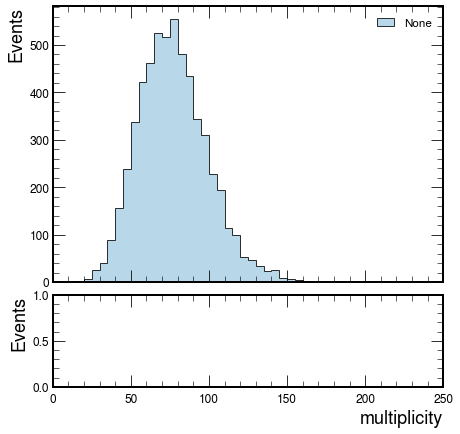

In [9]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

# Here is an example of setting up a color cycler to color the various fill patches
# We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
from cycler import cycler
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

# plot the MC first
hist.plot1d(
    numerator,
    ax=ax,
    clear=False,
    stack=False,
    line_opts=None,
    fill_opts=fill_opts,
    error_opts=error_opts
)
# now the pseudodata, setting clear=False to avoid overwriting the previous plot
#hist.plot1d(
#    denominator,
#    ax=ax,
#    clear=False,
#    error_opts=data_err_opts
#)

ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.set_xlabel(None)
leg = ax.legend()

# now we build the ratio plot
hist.plotratio(
    num=numerator,
    denom=denominator,
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
)
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

# add some labels
cms = plt.text(0., 1., u"CMS Simulation work",
                  fontsize=16,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137 fb$^{-1}$ (13 TeV)",
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )